# Constant‑Weave Visual Suite (v11)
Run **Runtime → Run all**.

In [5]:

import numpy as np, matplotlib.pyplot as plt, sympy as sp, networkx as nx
import plotly.graph_objs as go, plotly.io as pio, matplotlib.animation as anim, ipywidgets as wd
pio.renderers.default = "colab"


In [6]:

def fib_word(n:int):
    a,b='0','01'
    while len(b)<n: a,b=b,a+b
    return np.frombuffer(b[:n].encode(),dtype=np.uint8)-48

def random_mask(n): return np.random.randint(0,2,size=n,dtype=np.uint8)

size = 7
fib_bits = fib_word(size*size).reshape(size,size)
rnd_bits = random_mask(size*size).reshape(size,size)


## 1  Heat‑maps (Fibonacci vs Random)

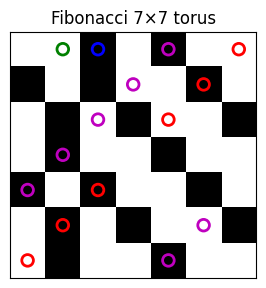

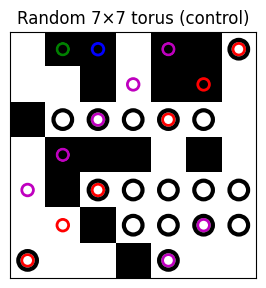

In [7]:
def show_torus(bits, title):
    primes=[p for p in range(2,size*size+1) if sp.isprime(p)]
    colmap={1:'r',2:'g',3:'b',4:'c',5:'m',6:'y'}
    seq=''.join('1' if b else '0' for b in bits.flatten())
    forb=[i for i in range(size*size) if seq[i:i+3] in ('000','110','111')]

    fig,ax=plt.subplots(figsize=(3.2,3.2))
    ax.imshow(bits,cmap='Greys',interpolation='none')
    for p in primes:
        r,c=divmod(p-1,size)
        ax.scatter(c,r,s=70,facecolors='none',edgecolors=colmap[(p-1)%6 + 1],lw=2)
    for k in forb:
        r,c=divmod(k,size)
        ax.scatter(c,r,s=180,facecolors='none',edgecolors='k',lw=3)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title(title); plt.show()

show_torus(fib_bits,"Fibonacci 7×7 torus")
show_torus(rnd_bits,"Random 7×7 torus (control)")

## 2  Interactive 3‑D torus (with primes)

In [8]:

def plot_torus(bits, title):
    N = bits.shape[0]*9
    bits_hi = np.kron(bits, np.ones((9,9)))
    R,r = 3,1
    th = np.linspace(0,2*np.pi,N,endpoint=False)
    ph = np.linspace(0,2*np.pi,N,endpoint=False)
    TH,PH = np.meshgrid(th,ph,indexing='ij')
    X=(R+r*np.cos(PH))*np.cos(TH)
    Y=(R+r*np.cos(PH))*np.sin(TH)
    Z=r*np.sin(PH)+bits_hi*0.6
    surf = go.Surface(x=X,y=Y,z=Z,colorscale='Greys',showscale=False)

    # prime overlay
    primes=[p for p in range(2,size*size+1) if sp.isprime(p)]
    px,py,pz=[],[],[]
    for p in primes:
        r0,c0=divmod(p-1,size)
        rr,cc=r0*9+4, c0*9+4
        px.append(X[rr,cc]); py.append(Y[rr,cc]); pz.append(Z[rr,cc]+0.05)
    dots = go.Scatter3d(x=px,y=py,z=pz,mode='markers',
                        marker=dict(size=4,color='red'))

    fig=go.Figure(data=[surf,dots])
    fig.update_layout(title=title,
                      scene=dict(aspectratio=dict(x=1,y=1,z=0.4)))
    fig.show()

plot_torus(fib_bits,"Fibonacci torus (primes in red)")


## 3  Rolling 7×7 window animation

In [9]:

seq_long=fib_word(300)
fig2,ax2=plt.subplots(figsize=(3,3)); ax2.axis('off')
frames=[[ax2.imshow(seq_long[i:i+49].reshape(7,7),cmap='Greys',interpolation='none')]
        for i in range(60)]
ani=anim.ArtistAnimation(fig2,frames,interval=180,blit=True)
plt.close(fig2)
from IPython.display import HTML; HTML(ani.to_jshtml())


## 4  Plateau vs Run‑length regression

/tmp/ipython-input-10-1936236012.py:4: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning:

invalid value encountered in scalar divide



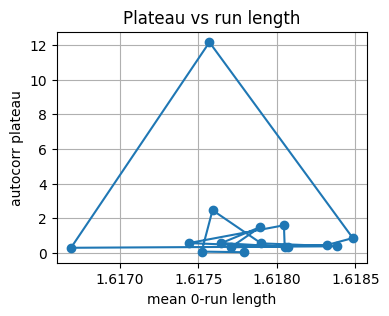

In [10]:

def plateau(bits):
    ac=np.correlate(bits.flatten(),bits.flatten(),mode='full')
    mid=len(ac)//2
    return ac[mid+1000:].mean()/ac[mid]   # normalised

def mean_zero_run(bits):
    runs = [len(list(g)) for b,g in groupby(bits.flatten()) if b==0]
    return np.mean(runs)

from itertools import groupby
sizes=np.arange(7,65,2)
plats,runlens=[],[]
for s in sizes:
    b=fib_word(s*s).reshape(s,s)
    plats.append(plateau(b))
    runlens.append(mean_zero_run(b))

plt.figure(figsize=(4,3))
plt.plot(runlens,plats,'o-'); plt.xlabel('mean 0‑run length')
plt.ylabel('autocorr plateau'); plt.title('Plateau vs run length'); plt.grid()
plt.show()


## 5  Factorial leak‑tank simulation

/tmp/ipython-input-11-1750546597.py:12: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



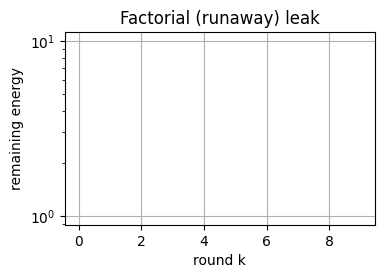

In [11]:

def leak_tank(n):
    remaining=1.0
    out=[]; leak=1
    for k in range(1,n+1):
        remaining -= 1/leak   # each outlet drains 1 unit per tick
        out.append(max(remaining,0))
        leak *= (k+1)
    return np.array(out)

vals=leak_tank(10)
plt.figure(figsize=(4,2.5))
plt.plot(vals,'o-'); plt.yscale('log'); plt.xlabel('round k'); plt.ylabel('remaining energy')
plt.title('Factorial (runaway) leak'); plt.grid(); plt.show()


## 6  FFT sphere (Fibonacci vs Random)

In [12]:

def fft_sphere(bits,title):
    a=np.abs(np.fft.fftshift(np.fft.fft2(bits)))/bits.size
    coords=[(i,j,a[i%bits.shape[0],j%bits.shape[1]])
            for i in range(-3,4) for j in range(-3,4)]
    x,y,z=zip(*coords)
    r=np.sqrt(np.array(x)**2+np.array(y)**2)+1e-9
    th=np.arctan2(y,x); ph=r/3*np.pi/2
    X=np.cos(th)*np.sin(ph); Y=np.sin(th)*np.sin(ph); Z=np.cos(ph)
    fig=go.Figure(data=[go.Scatter3d(x=X,y=Y,z=Z,mode='markers',
                      marker=dict(size=6,color=np.log1p(z),colorscale='plasma'))])
    fig.update_layout(title=title,
        scene=dict(xaxis_visible=False,yaxis_visible=False,zaxis_visible=False))
    fig.show()

fft_sphere(fib_bits,"FFT sphere – Fibonacci")
fft_sphere(rnd_bits,"FFT sphere – Random control")
